In [1]:
import pytz, os, sys, warnings

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sys.path.append(os.path.join(os.getcwd(), '..'))

from scripts.decomposition import perform_mstl
from scripts.ingest import build_mta_df, get_combined_residuals_df
from scripts.filter import split_df_at_datetime, TimeInterval
from scripts.model import *
from scripts.parameter_search import *


In [2]:
assets_path = os.path.join(os.getcwd(), '..', 'assets')

hourly_subway_df, hourly_bus_df, weather_df = build_mta_df(
    os.path.join(assets_path, 'hourly_subway_ridership.csv'),
    os.path.join(assets_path, 'hourly_bus_ridership.csv'),
    os.path.join(assets_path, 'nyc_hourly_weather.csv')
)

/Users/perryscott/Desktop/MTA-Weather-Based-Prediction/notebooks/../scripts/ingest.py:14: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  hourly_bus_df['hour'] = pd.to_datetime(hourly_bus_df['hour'])
/Users/perryscott/Desktop/MTA-Weather-Based-Prediction/notebooks/../scripts/ingest.py:15: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  hourly_subway_df['hour'] = pd.to_datetime(hourly_subway_df['hour'])


In [3]:
# Perform MSTL decomposition for subway data
subway_decomposition = perform_mstl(hourly_subway_df['total_ridership'], periods=[24, 24*7])

# Perform MSTL decomposition for bus data
bus_decomposition = perform_mstl(hourly_bus_df['total_ridership'], periods=[24, 24*7])


Read in weather data

In [4]:
combined_df = get_combined_residuals_df(hourly_subway_df, hourly_bus_df, weather_df, subway_decomposition, bus_decomposition)

In [5]:
# Filter to only include rows with precipitation > 0
rainy_df = combined_df[combined_df['Precipitation (in)'] > 0].copy()
print(f"Original dataset size: {len(combined_df)}")
print(f"Dataset size with only precipitation > 0: {len(rainy_df)}")


Original dataset size: 166971
Dataset size with only precipitation > 0: 19768


In [6]:

# Run analysis
time_intervals = [
    TimeInterval('Spring', 'weekend', (12, 14))
]

# Initialize models
models = {
    'Linear': LinearModel(),
    'GLM': GLMModel(),
    'Quantile': QuantileModel(quantile=0.5),
    'Robust': RobustModel(),
    'GradientBoosting': GradientBoostingModel(),
    'XGBoost': XGBoostModel(n_estimators=10),
    'Naive': NaiveModel()
}

train_df, val_df = split_df_at_datetime(rainy_df, pd.Timestamp('2023-11-16'))

results = {}

modes = ['subway', 'bus']

for time_interval in time_intervals:
    for mode in modes:
        print(f"\nAnalysis for {mode.capitalize()} - {time_interval.summary}")
        print("-" * 80)
        
        # results = run_model_analysis(models, combined_df, mode, season, day_type, hours)
        
        # for model_name, result in results.items():
        #     print(f"\n{model_name} Results:")
        #     print("Metrics:", result['train_metrics'])
        #     print("Summary:", result['summary'])

        results[f'{mode}_{time_interval.summary}'] = run_model_analysis(models, train_df, mode, time_interval, val_df)

        for model_name, result in results[f'{mode}_{time_interval.summary}'].items():
            print(f"\n{model_name} Results:")
            print("Train Metrics:", result['train_metrics'])
            print("Train Residuals:", result['train_residual'])
            print("Validation Metrics:", result['val_metrics'])
            print("Validation Residuals:", result['val_residual'])
            print("Summary:", result['summary'])




Analysis for Subway - Spring weekend (12, 14)
--------------------------------------------------------------------------------

Linear Results:
Train Metrics: {'MAE': np.float64(6212.363020115167), 'MSE': np.float64(60869262.66610039), 'R-squared': 0.6288380351628953}
Train Residuals: 5495     -7187.254176
5496     -7187.254176
5497     -7187.254176
5498     -7187.254176
5499     -7187.254176
             ...     
79389   -33225.095424
79390   -33225.095424
79391   -33225.095424
79392   -33225.095424
79393   -33225.095424
Name: subway_residual, Length: 168, dtype: float64
Validation Metrics: {'MAE': np.float64(16529.839697810185), 'MSE': np.float64(402237057.61370933), 'R-squared': 0.5627220793580641}
Validation Residuals: 127589   -43200.134113
127590   -43200.134113
127591   -43200.134113
127592   -43200.134113
127593   -43200.134113
127594   -43200.134113
127595   -43200.134113
127596   -45942.908168
127597   -45942.908168
127598   -45942.908168
127599   -45942.908168
127600   -459

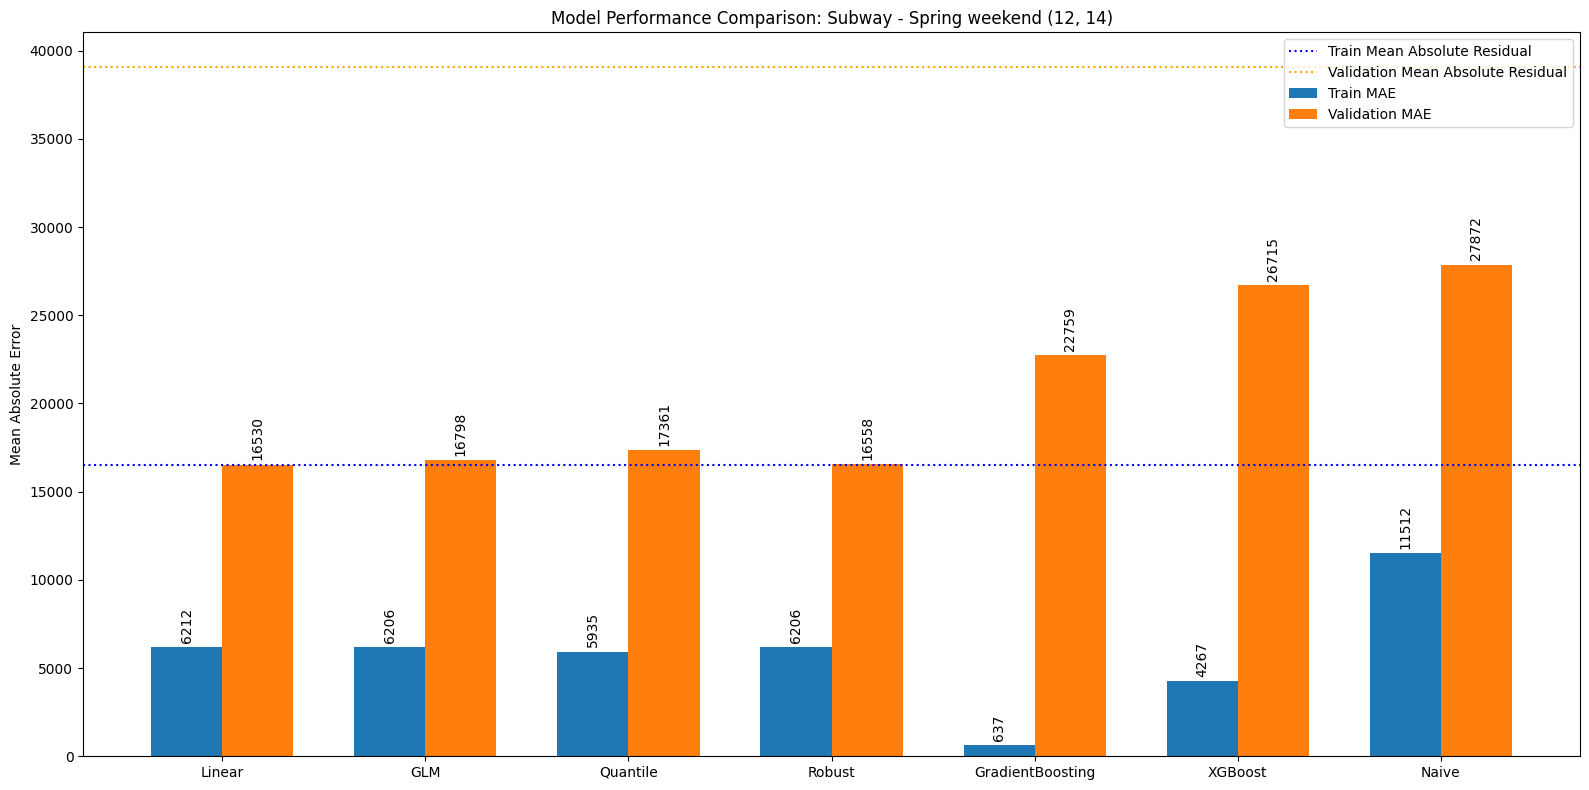

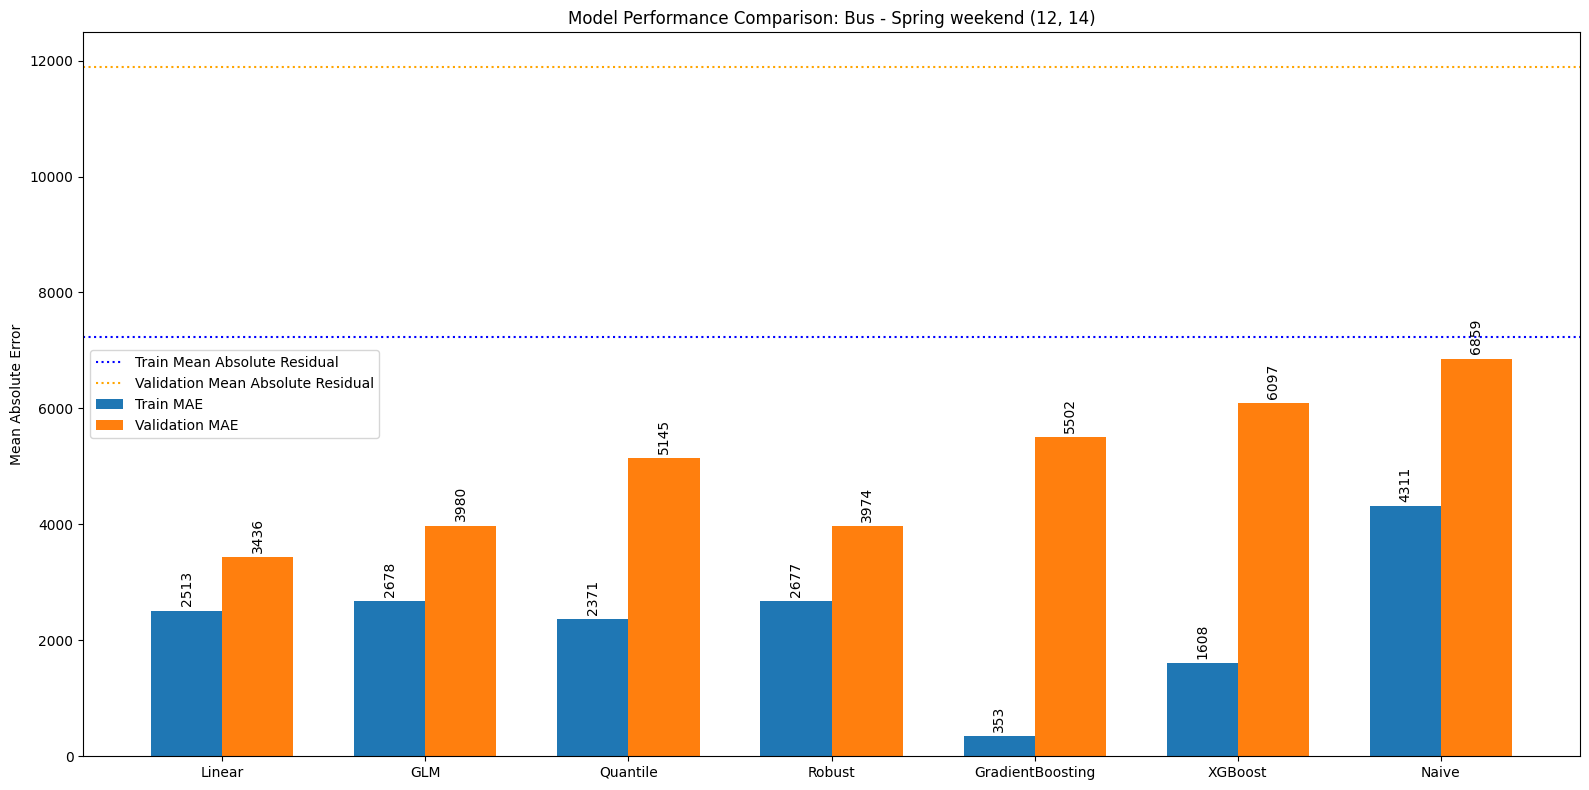

In [7]:
# Create bar plots comparing train vs validation MAE for each condition
import matplotlib.pyplot as plt
import numpy as np

def autolabel(ax, rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.0f}',
                    xy=(rect.get_x() + rect.get_width()/2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom', rotation=90)

# Create a plot for each condition
for time_interval in time_intervals:
    for mode in modes:
        
        # Extract results for this condition
        condition_results = results[f'{mode}_{time_interval.summary}']
        
        # Extract MAE values for each model
        model_names = list(condition_results.keys())
        train_maes = [result['train_metrics']['MAE'] for result in condition_results.values()]
        val_maes = [result['val_metrics']['MAE'] for result in condition_results.values()]
        
        # Calculate mean absolute residuals
        train_residuals = np.mean([abs(result['train_residual']) for result in condition_results.values()])
        val_residuals = np.mean([abs(result['val_residual']) for result in condition_results.values()])

        # Set up bar plot
        x = np.arange(len(model_names))
        width = 0.35

        fig, ax = plt.subplots(figsize=(16, 8))
        train_bars = ax.bar(x - width/2, train_maes, width, label='Train MAE')
        val_bars = ax.bar(x + width/2, val_maes, width, label='Validation MAE')
        
        # Add horizontal lines for mean absolute residuals
        ax.axhline(y=train_residuals, color='blue', linestyle=':', label='Train Mean Absolute Residual')
        ax.axhline(y=val_residuals, color='orange', linestyle=':', label='Validation Mean Absolute Residual')

        # Customize plot
        ax.set_ylabel('Mean Absolute Error')
        ax.set_title(f'Model Performance Comparison: {mode.capitalize()} - {time_interval.summary}')
        ax.set_xticks(x)
        ax.set_xticklabels(model_names)
        ax.legend()

        # Add value labels on bars
        autolabel(ax, train_bars)
        autolabel(ax, val_bars)

        plt.tight_layout()
        plt.show()


In [15]:
# Suppress specific statsmodels warning
warnings.filterwarnings('ignore', category=UserWarning, module='statsmodels')

# Define time intervals for parameter search
# time_intervals = [
#     TimeInterval('Spring', 'weekend', (0, 8)),
#     TimeInterval('Spring', 'weekend', (8, 16)),
#     TimeInterval('Spring', 'weekend', (16, 24)),
#     TimeInterval('Spring', 'weekday', (0, 8)),
#     TimeInterval('Spring', 'weekday', (8, 16)),
#     TimeInterval('Spring', 'weekday', (16, 24)),
#     TimeInterval('Summer', 'weekend', (0, 8)),
#     TimeInterval('Summer', 'weekend', (8, 16)),
#     TimeInterval('Summer', 'weekend', (16, 24)),
#     TimeInterval('Summer', 'weekday', (0, 8)),
#     TimeInterval('Summer', 'weekday', (8, 16)),
#     TimeInterval('Summer', 'weekday', (16, 24))
# ]

time_intervals = [
    TimeInterval('Fall', 'weekend', (0, 8)),
    TimeInterval('Fall', 'weekend', (8, 16)),
    TimeInterval('Fall', 'weekend', (16, 24)),
    TimeInterval('Fall', 'weekday', (0, 8)),
    TimeInterval('Fall', 'weekday', (8, 16)),
    TimeInterval('Fall', 'weekday', (16, 24)),
    TimeInterval('Winter', 'weekend', (0, 8)),
    TimeInterval('Winter', 'weekend', (8, 16)),
    TimeInterval('Winter', 'weekend', (16, 24)),
    TimeInterval('Winter', 'weekday', (0, 8)),
    TimeInterval('Winter', 'weekday', (8, 16)),
    TimeInterval('Winter', 'weekday', (16, 24))
]

# Get all possible feature combinations
feature_combinations = generate_feature_combinations([
    ModelParameters.TEMPERATURE,
    ModelParameters.PRECIPITATION, 
    ModelParameters.HUMIDITY,
    ModelParameters.CLOUD_COVER,
    ModelParameters.PRESSURE
])

# print(f"Number of feature combinations: {len(feature_combinations)}")
# for i, combo in enumerate(feature_combinations):
#     print(f"{i}: {combo}")

# Run parameter search for each mode
modes = ['subway', 'bus']
search_results = {}

for mode in modes:
    # Evaluate models with different parameter combinations
    mode_results = search_models_and_parameters(
        models=models,
        train_data=train_df,
        val_data=val_df,
        mode=mode,
        time_intervals=time_intervals,
        parameter_combinations=feature_combinations
    )    
    # Store results
    search_results[mode] = mode_results


    ordered_mode_results = order_averaged_scores(mode_results, mae_objective)

    print(f"Ordered mode results {ordered_mode_results}:")
    # Print top 5 feature combinations for this mode
    n = 50
    print(f"\nTop {n} feature combinations for {mode}:")
    for (model_name, params, score) in ordered_mode_results[:n]:
        param_names = [p.value for p in params]
        print(f"Score: {score:.4f} - Features: {param_names} - Model: {model_name}")


Ordered mode results [('Quantile', [<ModelParameters.PRESSURE: 'Pressure (inHg)'>], np.float64(9931.119796342044)), ('Quantile', [<ModelParameters.CLOUD_COVER: 'Cloud Cover (%)'>], np.float64(10016.295603848086)), ('Quantile', [<ModelParameters.TEMPERATURE: 'Temperature (°F)'>, <ModelParameters.PRESSURE: 'Pressure (inHg)'>], np.float64(10025.576756486955)), ('Quantile', [<ModelParameters.TEMPERATURE: 'Temperature (°F)'>], np.float64(10037.372835789061)), ('Quantile', [<ModelParameters.TEMPERATURE: 'Temperature (°F)'>, <ModelParameters.CLOUD_COVER: 'Cloud Cover (%)'>], np.float64(10080.298544748734)), ('Robust', [<ModelParameters.PRESSURE: 'Pressure (inHg)'>], np.float64(10092.071158502162)), ('GradientBoosting', [<ModelParameters.TEMPERATURE: 'Temperature (°F)'>], np.float64(10094.850600334086)), ('Quantile', [<ModelParameters.TEMPERATURE: 'Temperature (°F)'>, <ModelParameters.CLOUD_COVER: 'Cloud Cover (%)'>, <ModelParameters.PRESSURE: 'Pressure (inHg)'>], np.float64(10135.45608882438)

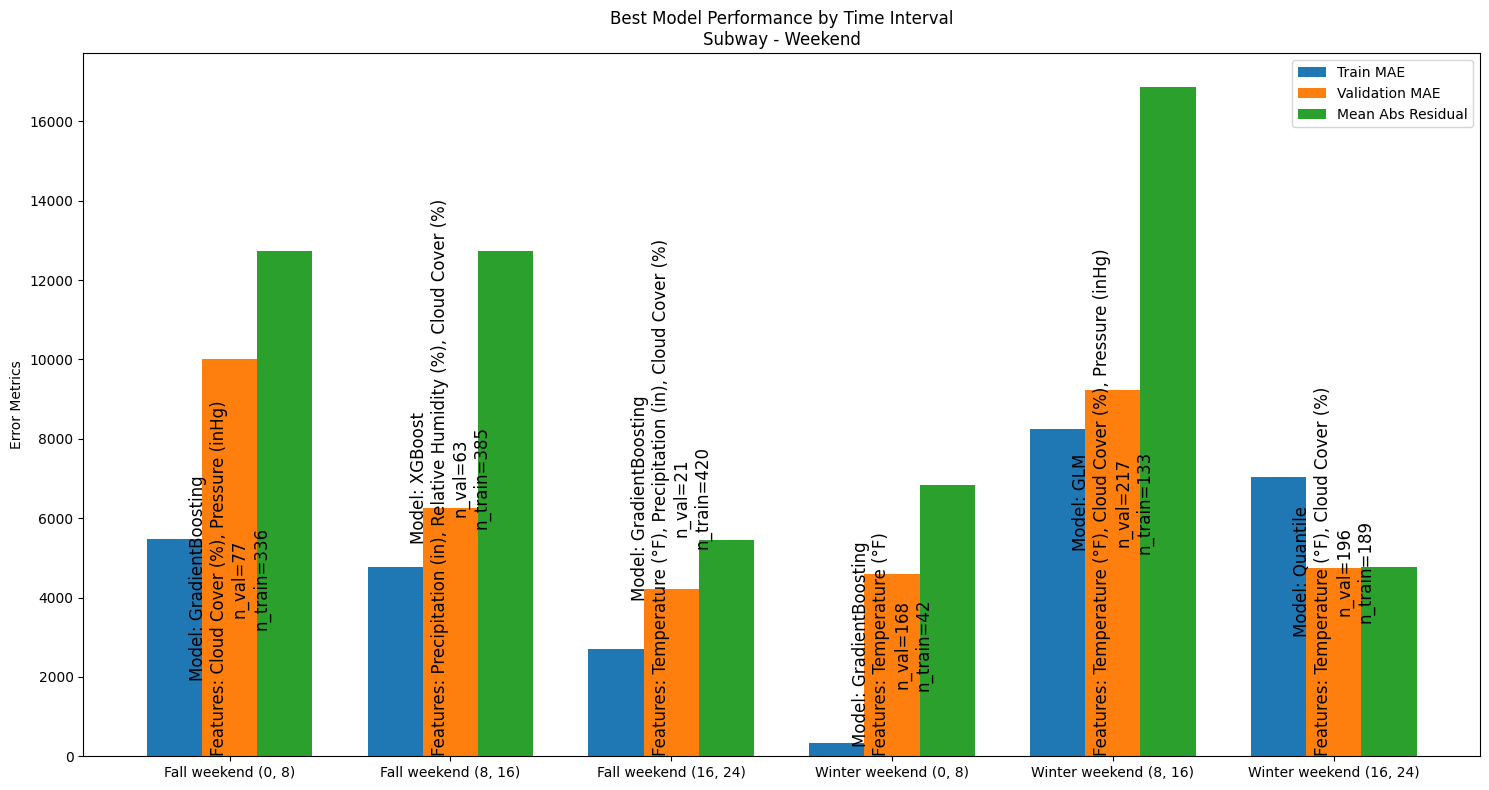

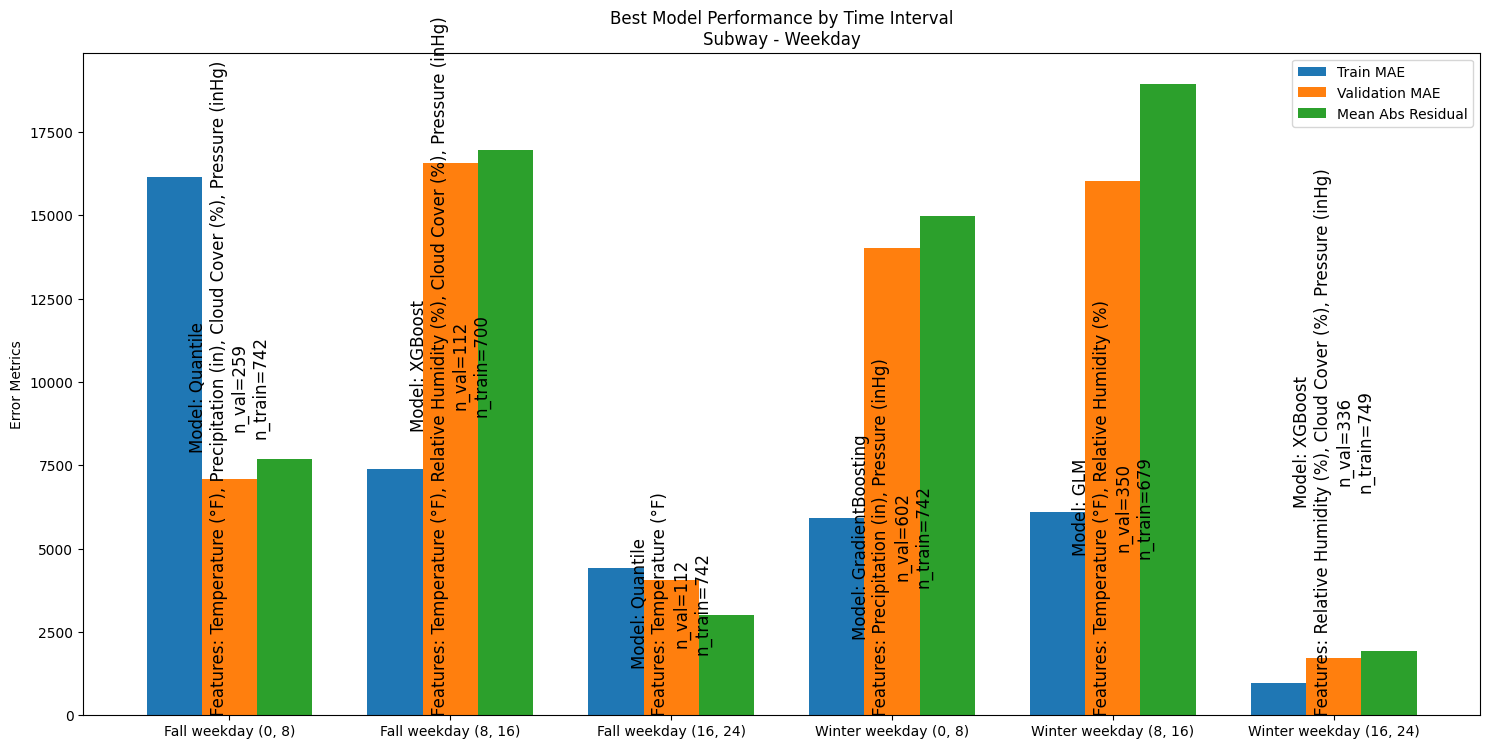

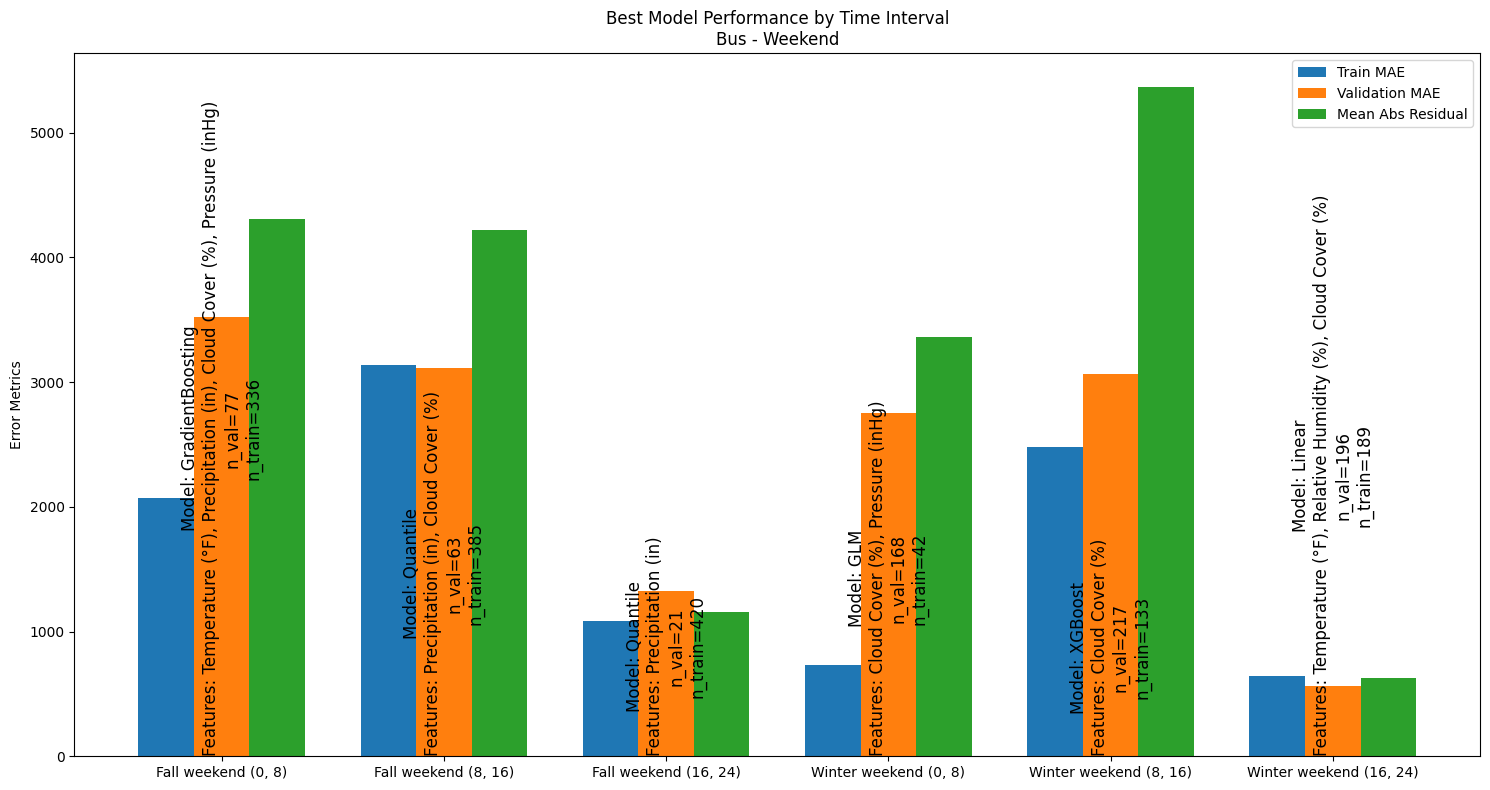

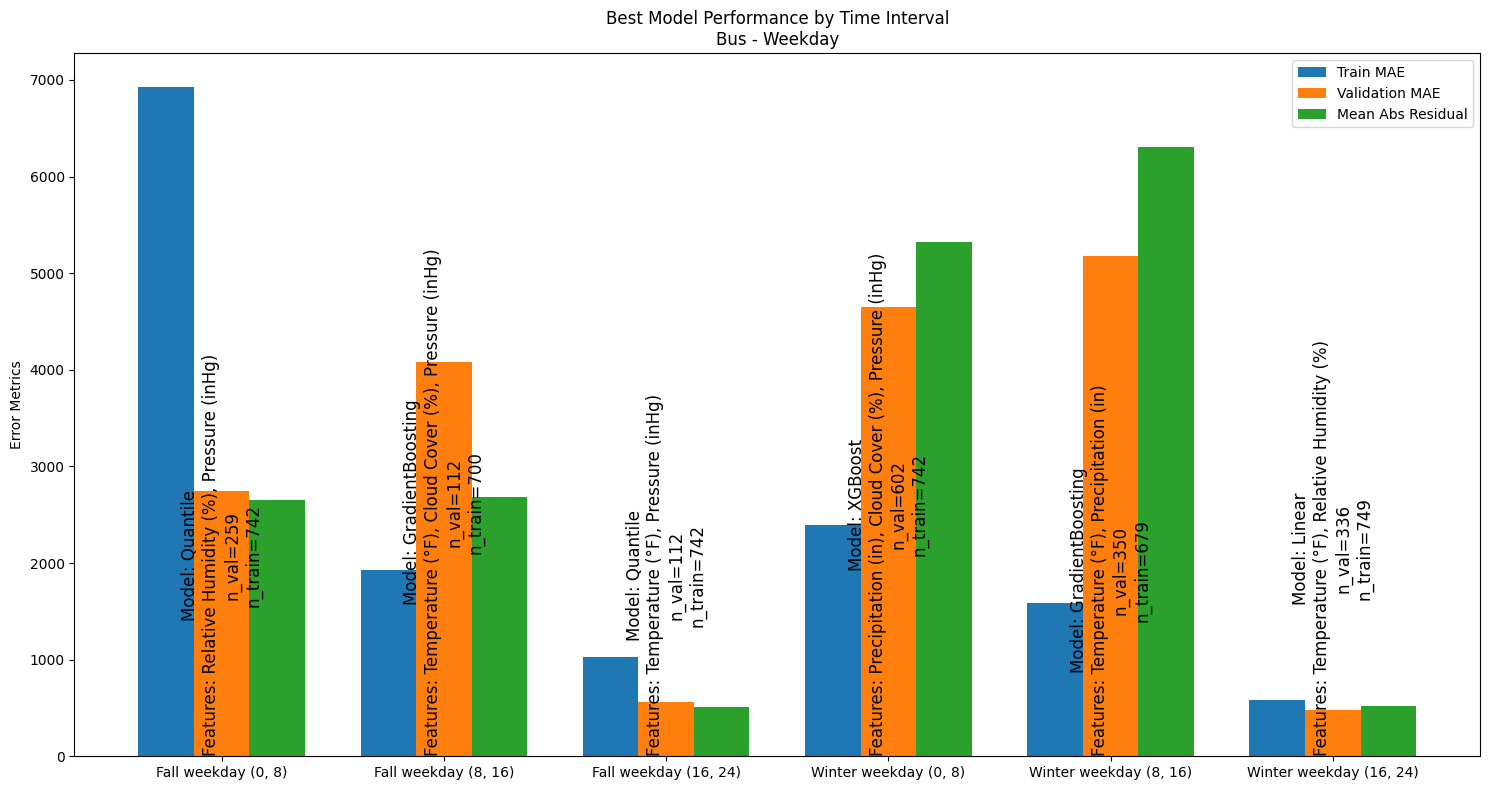

In [17]:
def get_best_models_by_interval(search_results, mode, day_type):
    best_models = {}
    
    # Get all results for this mode
    mode_results = search_results[mode]
    
    # Filter results by day type and find best model for each interval
    for result in mode_results:
        interval = result["time_interval"]
        if interval.day_type != day_type:
            continue
            
        model_results = result["model_results"]
        parameters = result["parameters"]
        
        # Initialize best configuration for this interval if not exists
        if interval not in best_models:
            best_models[interval] = {
                'model_name': None,
                'features': None,
                'train_mae': float('inf'),
                'val_mae': float('inf'),
                'val_residual': None,
                'n_samples': 0
            }
            
        # Check each model's performance
        for model_name, metrics in model_results.items():
            val_mae = metrics['val_metrics']['MAE']
            if val_mae < best_models[interval]['val_mae']:
                best_models[interval] = {
                    'model_name': model_name,
                    'features': [p.value for p in parameters],
                    'train_mae': metrics['train_metrics']['MAE'],
                    'val_mae': val_mae,
                    'val_residual': np.mean(np.abs(metrics['val_residual'])),
                    'n_samples_val': len(metrics['val_residual']),
                    'n_samples_train': len(metrics['train_residual'])
                }
    
    return best_models

# Rest of the plotting code remains the same...

# Create plots for each mode and day type
for mode in modes:
    for day_type in ['weekend', 'weekday']:
        best_models = get_best_models_by_interval(search_results, mode, day_type)
        
        # Set up the plot
        fig, ax = plt.subplots(figsize=(15, 8))
        
        # Prepare data for plotting
        intervals = [interval.summary for interval in best_models.keys()]
        x = np.arange(len(intervals))
        width = 0.25
        
        # Create bars
        train_bars = ax.bar(x - width, [m['train_mae'] for m in best_models.values()], width, label='Train MAE')
        val_bars = ax.bar(x, [m['val_mae'] for m in best_models.values()], width, label='Validation MAE')
        residual_bars = ax.bar(x + width, [m['val_residual'] for m in best_models.values()], width, label='Mean Abs Residual')
        
        # Customize plot
        ax.set_ylabel('Error Metrics')
        ax.set_title(f'Best Model Performance by Time Interval\n{mode.capitalize()} - {day_type.capitalize()}')
        ax.set_xticks(x)
        ax.set_xticklabels(intervals)
        ax.legend()
        
        # Add model details as annotations
        for idx, (interval, model) in enumerate(best_models.items()):
            ax.text(idx, 0, 
                   f"Model: {model['model_name']}\nFeatures: {', '.join(model['features'])}\nn_val={model['n_samples_val']}\nn_train={model['n_samples_train']}", 
                   rotation=90, 
                   va='bottom', 
                   ha='center',
                   fontsize=12)
        
        plt.tight_layout()
        plt.show()